In [1]:
import pandas as pd
import numpy as np

In [2]:
import json
with open("./Accord_all_contract_NER.json", "r") as f:
    templates = json.load(f)

In [3]:
templates.keys()

dict_keys(['helloworld', 'signature-block-title-name-date', 'latedeliveryandpenalty-currency-conversion', 'payment-upon-delivery', 'supply-agreement-loc', 'latedeliveryandpenalty', 'promissory-note', 'latedeliveryandpenalty-optional-this', 'rental-deposit-with', 'certificate-of-incorporation', 'empty', 'car-rental-tr', 'fragile-goods', 'supplyagreement', 'promissory-note-md', 'lateinvoicewithpayment', 'bill-of-lading', 'volumediscount', 'perishable-goods', 'servicelevelagreement', 'supplyagreement-perishable-goods', 'docusign-po-failure', 'fixed-interests-static', 'company-information', 'volumediscountolist', 'contact-information', 'acceptance-of-delivery', 'installment-sale', 'hellomodule', 'copyright-license', 'saft', 'minilatedeliveryandpenalty-capped', 'payment-upon-iot', 'volumediscountulist', 'latedeliveryandpenalty-optional', 'safte', 'interest-rate-swap', 'docusign-connect', 'demandforecast', 'rental-deposit', 'sales-contract-ru', 'empty-contract', 'one-time-payment-tr', 'simpl

In [4]:
results = {}

import tqdm
from transformers import AutoTokenizer
# b) Load model & tokenizer
model_name = "roberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)

for name, template in tqdm.tqdm(templates.items()):


    import difflib

    d = difflib.Differ()


    predict_y = []
    for i, token in enumerate(template['NER']['prediction']):
        try:
            if token['prediction'][0]['type'] == "O":
                predict_y.append(0)
            else:
                predict_y.append(1)
        except:
            token['prediction'] = token['predictions']
            if token['predictions'][0]['type'] == "O":
                predict_y.append(0)
            else:
                predict_y.append(1)


    sample = tokenizer.tokenize("".join(template['/text/sample.md']))
    grammar = tokenizer.tokenize("".join(template['/text/grammar.tem.md']))

    diff = d.compare(sample, grammar)
    diff = list(diff)

    sample_with_mark = list(filter(lambda x: x[0] in ["-", " "], diff))

    true_y = []
    for i, token in enumerate(sample_with_mark):
        if token in ['- Ġ"', '- "', '".', "Ċ"] or 'Ċ' in token:
            true_y.append(0)
            predict_y[i] = 0
        elif token[0] == "-" and token not in ['- Ġ"', '- "', '".', "Ċ"] and '"' not in token and "'" not in token:
            true_y.append(1)
        else:
            true_y.append(0)

    np.array(true_y) == np.array(predict_y)
    results[name] = {"true_y": np.array(true_y), "predict_y": np.array(predict_y)}

2023-02-20 15:08:50.467064: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
100%|█████████████████████████| 56/56 [00:00<00:00, 131.61it/s]


In [5]:
from sklearn.metrics import confusion_matrix, f1_score

In [6]:
f1s = []
total = np.array([])
total_true_y = np.array([])
total_pred_y = np.array([])
for name, result in results.items():
    total = np.append(total, [(result['true_y'] == result['predict_y']).astype(int)])
    total_true_y = np.append(total_true_y, [(result['true_y']).astype(int)])
    total_pred_y = np.append(total_pred_y, [(result['predict_y']).astype(int)])
    f1s.append({'name':name, 'f1': f1_score(result['true_y'], result['predict_y'])})

/home/eason/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/eason/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [7]:
results['helloworld']

{'true_y': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]),
 'predict_y': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0])}

In [8]:
f1_score(total_true_y, total_pred_y)

0.3195759840125119

In [9]:
names = list(templates.keys())

In [10]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [11]:
f1 = f1_score(results[name]['true_y'], results[name]['predict_y'])

In [12]:
print(f"")

In [ ]:
f1_score(np.array([1]*42), np.array([1]*40 + [0] * 2))

In [13]:
def f(i):
    name = names[i]
    print(name)
    tokens = tokenizer.tokenize("".join(templates[name]['/text/sample.md']))
    texts = ""
    wrongs = []
    for i, token in enumerate(tokens):

        if results[name]['true_y'][i] != results[name]['predict_y'][i]:
            texts += ("!ERR!")
            wrongs.append(f'{token}: {templates[name]["NER"]["prediction"][i]["prediction"][0]["type"]}')
        texts += (token)
    f1 = f1_score(results[name]['true_y'], results[name]['predict_y'])
    print(f"{f1:.2f}: ", texts.replace("Ġ", " "))
    print(wrongs)
interact(f, i=(0,len(names)));

interactive(children=(IntSlider(value=28, description='i', max=56), Output()), _dom_classes=('widget-interact'…

In [14]:
df = pd.DataFrame(f1s).sort_values("f1", ascending=False).reset_index(drop=True)
df.to_csv("NER_f1s.csv")

In [15]:
from sklearn.preprocessing import KBinsDiscretizer

In [16]:
kb = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')

In [17]:
df['10_bin'] = kb.fit_transform(np.array(df.f1).reshape(-1, 1)).reshape(-1)

In [18]:
df['num'] = 1

In [19]:
df.to_csv("NER_f1s.csv")

In [20]:
from matplotlib import pyplot as plt

In [21]:

kb = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')

res = kb.fit_transform(np.array(df.f1).reshape(-1, 1)).reshape(-1)

In [22]:
types, count = np.unique(res, return_counts=True)

In [23]:
x = []
y = []
for i in range(20):
    x.append(i)
    if count[i == types]:
        y.append(float(count[i == types] / len(res)))
    else:
        y.append(0)

In [24]:
total = 0
cul_y = []
for i in y:
    total += i
    cul_y.append(float(total))

In [25]:
y

[0.07142857142857142,
 0.017857142857142856,
 0.017857142857142856,
 0.07142857142857142,
 0.017857142857142856,
 0.03571428571428571,
 0.017857142857142856,
 0.03571428571428571,
 0.017857142857142856,
 0.05357142857142857,
 0.05357142857142857,
 0.05357142857142857,
 0.05357142857142857,
 0.07142857142857142,
 0.10714285714285714,
 0.05357142857142857,
 0.08928571428571429,
 0.05357142857142857,
 0.03571428571428571,
 0.07142857142857142]

In [26]:
def hist(data, bins, title, labels, range = None):
    fig = plt.figure(figsize=(15, 8))
    ax = plt.axes()
    plt.ylabel("Proportion")
    values, base, _ = plt.hist( data  , bins = bins, density=True, alpha = 0.5, color = "green", range = range, label = "Histogram")
    ax_bis = ax.twinx()
    values = np.append(values,0)
    ax_bis.plot( base, np.cumsum(values)/ np.cumsum(values)[-1], color='darkorange', marker='o', linestyle='-', markersize = 1, label = "Cumulative Histogram" )
    plt.xlabel(labels)
    plt.ylabel("Proportion")
    plt.title(title)
    ax_bis.legend();
    ax.legend();
    plt.show()
    return

In [27]:
from matplotlib import rc
import matplotlib
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'cursive','serif':['Times']})
matplotlib.rcParams['font.family'] = ['Source Han Sans TW', 'sans-serif']
# rc('text', usetex=True)

In [28]:
from matplotlib import font_manager

import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

font_manager.fontManager.addfont("/home/eason/Python/Downloads/NotoSans-Regular.ttf")

# set font
plt.rcParams['font.family'] = 'Noto Sans CJK JP'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [29]:
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties as font
font_ = font("/home/eason/Python/Downloads/NotoSansRegular.ttf")

In [30]:
import matplotlib
matplotlib.__file__

'/home/eason/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/__init__.py'

In [40]:
__author__ = 'Katherine'
from matplotlib.font_manager import FontManager
import subprocess

fm = FontManager()
mat_fonts = set(f.name for f in fm.ttflist)

output = subprocess.check_output(
    'fc-list :lang=zh -f "%{family}\n"', shell=True)
output = output.decode('utf-8')
# print '*' * 10, '系统可用的中文字体', '*' * 10
# print output
zh_fonts = set(f.split(',', 1)[0] for f in output.split('\n'))
available = mat_fonts & zh_fonts

print('*' * 10, '可用的字体', '*' * 10)
for f in available:
    print(f)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
********** 可用的字体 **********
Noto Sans CJK JP
Noto Serif CJK JP
Droid Sans Fallback


findfont: Font family ['/home/eason/Python/Downloads/NotoSansRegular.ttf'] not found. Falling back to DejaVu Sans.
/home/eason/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 36889 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/eason/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 26159 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/eason/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 22294 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/eason/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 34920 missing from current font.
  font.set_text(s, 0.0, flags=flags)
findfont: Font family ['NotoSans Regular'] not found. Falling back to DejaVu Sans.
/home/eason/anaconda3/envs/py37/li

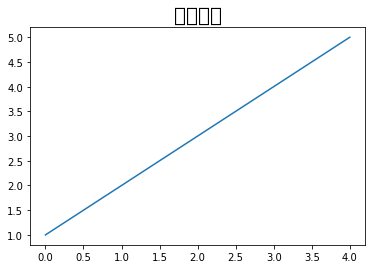

In [31]:

x = [1,2,3,4,5]
fig = plt.figure()
plt.plot(x)
# 設定 fontproperties 參數，指定字型
plt.title('這是圖表', fontproperties=font_, fontsize=20)
plt.show()

In [38]:
[(180,183,198)]

[(180, 183, 198)]

In [46]:
plt.rcParams['font.family'] = 'Noto Serif CJK JP'

In [68]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

In [69]:
import matplotlib 
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 

/home/eason/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


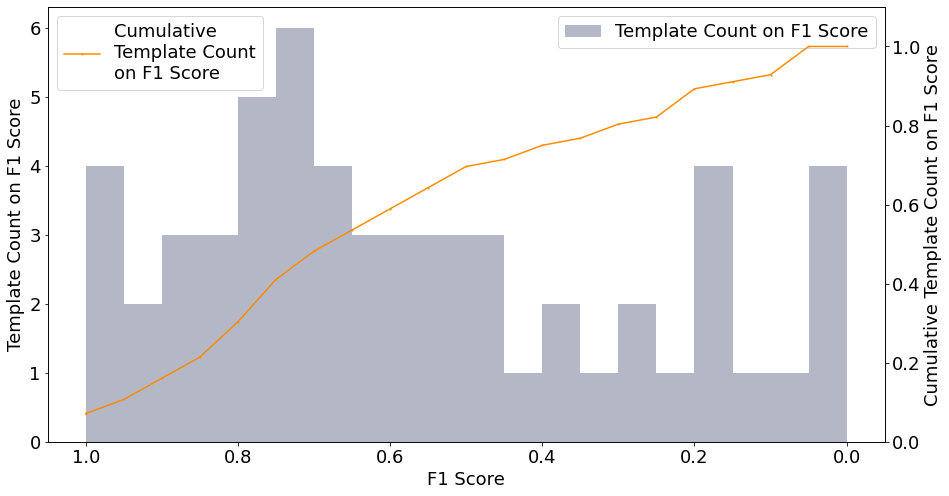

In [74]:
data, bins, title, labels = (np.array(df.f1), 20, "", (np.array(x)/20))

fig = plt.figure(figsize=(15, 8))
ax = plt.axes()
y_label_1 = "Template Count on F1 Score"
y_label_2 = "Cumulative Template Count on F1 Score"
plt.ylabel(y_label_1,)
plt.xlabel("F1 Score")

values, base, _ = plt.hist( data  , bins = bins, alpha = 1, color = [(180/255,183/255,198/255)],  label = y_label_1)
# ax.set_ylim([0,5])
ax_bis = ax.twinx()
ax_bis.set_ylim([0,1.1])
values = np.append(values,0)

data2 = np.append(
(np.cumsum(values[::-1])/ np.cumsum(values[::-1])[-1])[1:], [1])[::-1]
ax_bis.plot( base, data2, color='darkorange', marker='o', linestyle='-', markersize = 1, label = "Cumulative \nTemplate Count\non F1 Score")
plt.xlabel(labels)
plt.ylabel(y_label_2)
plt.title(title)
ax_bis.legend(loc = "upper left");
ax.legend(loc = "upper right");
plt.gca().invert_xaxis()
plt.show()

<BarContainer object of 20 artists>

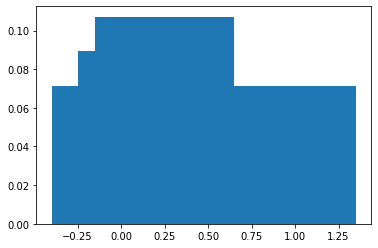

In [364]:
plt.bar((np.array(x)/20)[::-1], y)

/home/eason/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


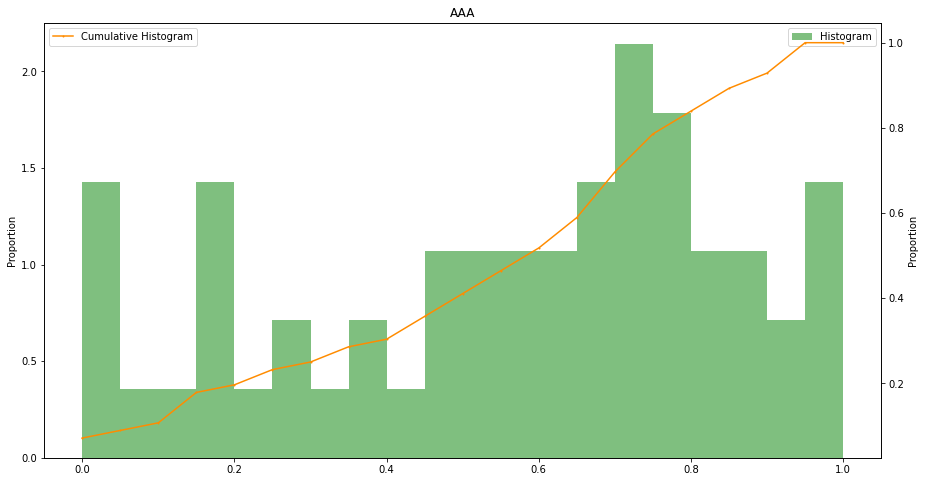

In [377]:
hist(np.array(df.f1), 20, "AAA", (np.array(x)/20))

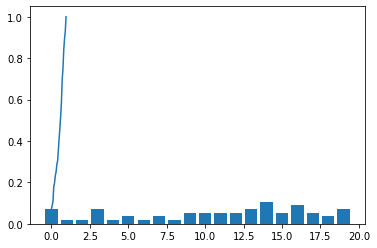

In [355]:

plt.plot(np.array(x)/20, cul_y)

In [281]:
kb.fit_transform(np.array(df.f1).reshape(-1, 1)).reshape(-1)

array([19., 19., 19., 19., 18., 18., 17., 17., 17., 16., 16., 16., 16.,
       16., 15., 15., 15., 14., 14., 14., 14., 14., 14., 13., 13., 13.,
       13., 12., 12., 12., 11., 11., 11., 10., 10., 10.,  9.,  9.,  9.,
        8.,  7.,  7.,  6.,  5.,  5.,  4.,  3.,  3.,  3.,  3.,  2.,  1.,
        0.,  0.,  0.,  0.])

In [264]:
pd.DataFrame(f1s).sort_values("f1", ascending=False)

,name,f1
0,helloworld,1.000000
3,payment-upon-delivery,1.000000
49,helloworldstate,1.000000
28,hellomodule,1.000000
47,full-payment-upon-demand,0.947368
18,perishable-goods,0.921348
55,payment-upon-signature,0.888889
54,minilatedeliveryandpenalty-payment,0.866667
31,minilatedeliveryandpenalty-capped,0.866667
15,lateinvoicewithpayment,0.842105


In [123]:
total.mean()

0.8082338646272604

In [124]:
def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
            TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
            FP += 1
        if y_actual[i]==y_pred[i]==0:
            TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
            FN += 1

    return(TP, FP, TN, FN)

In [125]:
TP, FP, TN, FN = perf_measure(total_true_y, total_pred_y)

In [127]:
confusion_matrix(total_true_y, total_pred_y, labels=[0, 1])

array([[32085,  7410],
       [  639,  1839]])

In [347]:
res

array([19., 19., 19., 19., 18., 18., 17., 17., 17., 16., 16., 16., 16.,
       16., 15., 15., 15., 14., 14., 14., 14., 14., 14., 13., 13., 13.,
       13., 12., 12., 12., 11., 11., 11., 10., 10., 10.,  9.,  9.,  9.,
        8.,  7.,  7.,  6.,  5.,  5.,  4.,  3.,  3.,  3.,  3.,  2.,  1.,
        0.,  0.,  0.,  0.])

In [71]:
confusion_matrix(total_true_y, total_pred_y, labels=[0, 1])

array([[32013,  7482],
       [  639,  1839]])

In [254]:
len(total_true_y)

41973

0.311721332316298

In [67]:
TP

1839

In [47]:
FP

1

In [48]:
TN

8134

In [49]:
FN

0

In [29]:
np.append([1, 2, 3], [[4, 5, 6], [7, 8, 9]])

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0])

[{'type': 'O', 'confidence': 0.9404129981994629},
 {'type': 'B-org', 'confidence': 0.24135534465312958},
 {'type': 'Organization', 'confidence': 0.2282179296016693}]

In [98]:
name

'helloworld'

In [100]:
predict_y

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0]

In [99]:
true_y

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]

In [28]:
"".join(template['/text/grammar.tem.md'])

'Upon the signing of this Agreement, {{buyer}} shall pay {{amount}} to {{seller}}.'

In [29]:
"".join(template['/text/sample.md'])

'Upon the signing of this Agreement, "Dave" shall pay 50 USD to "Dan".'

In [82]:
ans = pd.DataFrame({"true_y": true_y, "predict_y": predict_y})

In [83]:
ans

,true_y,predict_y
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,1
6,0,0
7,0,0
8,1,1
9,0,0


In [69]:
sample_with_mark

['  Upon',
 '  Ġthe',
 '  Ġsigning',
 '  Ġof',
 '  Ġthis',
 '  ĠAgreement',
 '  ,',
 '- Ġ"',
 '- Dave',
 '- "',
 '  Ġshall',
 '  Ġpay',
 '- Ġ50',
 '- ĠUSD',
 '  Ġto',
 '- Ġ"',
 '- Dan',
 '- ".']

['  Upon',
 '  Ġthe',
 '  Ġsigning',
 '  Ġof',
 '  Ġthis',
 '  ĠAgreement',
 '  ,',
 '- Ġ"',
 '- Dave',
 '- "',
 '+ Ġ{{',
 '+ buy',
 '+ er',
 '+ }}',
 '  Ġshall',
 '  Ġpay',
 '- Ġ50',
 '- ĠUSD',
 '+ Ġ{{',
 '+ amount',
 '+ }}',
 '  Ġto',
 '- Ġ"',
 '- Dan',
 '- ".',
 '+ Ġ{{',
 '+ seller',
 '+ }}',
 '+ .']

2023-02-09 11:49:04.071346: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [24]:
list(diff)

['  Upon',
 '  Ġthe',
 '  Ġsigning',
 '  Ġof',
 '  Ġthis',
 '  ĠAgreement',
 '  ,',
 '- Ġ"',
 '- Dave',
 '- "',
 '+ Ġ{{',
 '+ buy',
 '+ er',
 '+ }}',
 '  Ġshall',
 '  Ġpay',
 '- Ġ50',
 '- ĠUSD',
 '+ Ġ{{',
 '+ amount',
 '+ }}',
 '  Ġto',
 '- Ġ"',
 '- Dan',
 '- ".',
 '+ Ġ{{',
 '+ seller',
 '+ }}',
 '+ .']

In [12]:
difference("".join(template['/text/sample.md']), "".join(template['/text/grammar.tem.md']))


The Difference Between Two Strings: 
{'50', '{{seller}}.', '{{buyer}}', '"Dave"', 'USD', '"Dan".', '{{amount}}'}
The programs runs successfully.


In [10]:
def difference(string1, string2):
      # Split both strings into list items
  string1 = string1.split()
  string2 = string2.split()

  A = set(string1) # Store all string1 list items in set A
  B = set(string2) # Store all string2 list items in set B
 
  str_diff = A.symmetric_difference(B)
  isEmpty = (len(str_diff) == 0)
 
  if isEmpty:
    print("No Difference. Both Strings Are Same")
  else:
    print("The Difference Between Two Strings: ")
    print(str_diff)
  
  print('The programs runs successfully.')

# Driver code to call a function
usr_str1 = 'Educative is good'
usr_str2 = 'Educative is bad'
output = difference(usr_str1, usr_str2)


The Difference Between Two Strings: 
{'good', 'bad'}
The programs runs successfully.


In [7]:
template

{'/request.json': {'$class': 'org.accordproject.payment.PaymentReceived'},
 '/.cucumber.js': ["require('@accordproject/cicero-test').Steps;"],
 '/logic/logic.ergo': ['/*\n',
  ' * Licensed under the Apache License, Version 2.0 (the "License");\n',
  ' * you may not use this file except in compliance with the License.\n',
  ' * You may obtain a copy of the License at\n',
  ' *\n',
  ' * http://www.apache.org/licenses/LICENSE-2.0\n',
  ' *\n',
  ' * Unless required by applicable law or agreed to in writing, software\n',
  ' * distributed under the License is distributed on an "AS IS" BASIS,\n',
  ' * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n',
  ' * See the License for the specific language governing permissions and\n',
  ' * limitations under the License.\n',
  ' */\n',
  '\n',
  'namespace org.accordproject.payment.uponsignature\n',
  '\n',
  'import org.accordproject.runtime.*\n',
  'import org.accordproject.obligation.*\n',
  'import org.accordproject